<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/ORAN_Autoencoder_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/ORAN/Network_Dataset.csv")

Mounted at /content/gdrive


In [2]:
import pandas as pd


print(f"Total de colunas: {len(encoded.columns)}\n")
print(encoded.columns.tolist())

Total de colunas: 26

['uid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'history', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto', 'http_trans_depth', 'attack_category', 'attack_type', 'files_total_bytes', 'is_GET_mthd', 'http_status_error', 'is_file_transfered', 'traffic_type']


In [3]:
import pandas as pd

# Ver todos os tipos de ataque (categorias amplas)
print("Categorias de ataque:")
print(encoded['attack_category'].unique())

# Contar ocorrência de cada categoria
print("\nContagem por categoria:")
print(encoded['attack_category'].value_counts())

# Ver todos os tipos específicos de ataque
print("\nTipos específicos de ataque:")
print(encoded['attack_type'].unique())

# Contar ocorrência de cada tipo específico
print("\nContagem por tipo:")
print(encoded['attack_type'].value_counts())

Categorias de ataque:
['ddos' 'bruteforce' 'probe' 'web' 'dos' 'benign']

Contagem por categoria:
attack_category
dos           632507
ddos          420282
web           288304
probe         183293
benign        170865
bruteforce     28566
Name: count, dtype: int64

Tipos específicos de ataque:
['tcp_ack' 'syn' 'icmp' 'slowloris' 'udp' 'ssh' 'ftp' 'portscan_tcp'
 'os_fingerprinting' 'portscan_udp' 'http_flood' 'dir_bruteforce' 'benign'
 'xss' 'sql_injection']

Contagem por tipo:
attack_type
syn                  506451
http_flood           254314
udp                  227408
tcp_ack              199304
benign               170865
portscan_tcp         100000
slowloris             94887
os_fingerprinting     62957
dir_bruteforce        28566
icmp                  24739
portscan_udp          20336
ssh                   14902
ftp                   13664
xss                    3661
sql_injection          1763
Name: count, dtype: int64


In [4]:
pip install imbalanced-learn


In [5]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is inc

In [6]:
!pip install gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=04e0c1fd72ba09853582dd003933352e5fceb50d70e25d4ca01827c65543c89f
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil


In [7]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [8]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [9]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Início] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        #energy = calcular_energia(cpu, frequencia_cpu_ghz, tempo_execucao_epoca)
        #self.energy_usage.append(energy)
        print(f"[Epoch {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.2f} Joules")

        # Armazenar para uso externo
        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0

    # Cálculo de energia
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.2f} Joules")

    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [10]:
print(encoded['traffic_type'].unique())

[1 0]


In [11]:
# Criar label binária: 0 = benign, 1 = ataque
encoded['Label'] = encoded['traffic_type'].apply(lambda x: 0 if x == 0 else 1)

# Conferir
print(encoded[['traffic_type', 'Label']].head(10))
print("\nDistribuição das classes:")
print(encoded['Label'].value_counts())

   traffic_type  Label
0             1      1
1             1      1
2             1      1
3             1      1
4             1      1
5             1      1
6             1      1
7             1      1
8             1      1
9             1      1

Distribuição das classes:
Label
1    1552952
0     170865
Name: count, dtype: int64


In [12]:
#categorical_cols = ['src_ip', 'dst_ip', 'service', 'conn_state', 'history']

#for col in categorical_cols:
#    encoded[col] = LabelEncoder().fit_transform(encoded[col].astype(str))


====== Zero-Day: tcp_ack ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 13.60%, Memory: 2259.38 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 2307.71 MB

[Epoch 2 - Início] CPU: 1.20%, Memory: 2307.69 MB
[Epoch 2 - Fim] CPU: 1.30%, Memory: 2347.07 MB

[Epoch 3 - Início] CPU: 2.50%, Memory: 2347.05 MB
[Epoch 3 - Fim] CPU: 1.30%, Memory: 2355.71 MB

[Epoch 4 - Início] CPU: 8.60%, Memory: 2355.69 MB
[Epoch 4 - Fim] CPU: 2.40%, Memory: 2364.20 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 2364.18 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 2372.75 MB

[Epoch 6 - Início] CPU: 0.00%, Memory: 2372.73 MB
[Epoch 6 - Fim] CPU: 13.70%, Memory: 2381.08 MB

[Epoch 7 - Início] CPU: 13.60%, Memory: 2381.05 MB
[Epoch 7 - Fim] CPU: 2.40%, Memory: 2388.89 MB

[Epoch 8 - Início] CPU: 1.20%, Memory: 2388.87 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 2396.66 MB

[Epoch 9 - Início] CPU: 0.00%, Memory: 2396.64 MB
[Epoch 9 - Fim] CPU: 4.90%, Memory: 2404.15 MB

[Epoch 10 - Início] CPU: 0.00%, Memory: 2404.12 MB
[Epoc

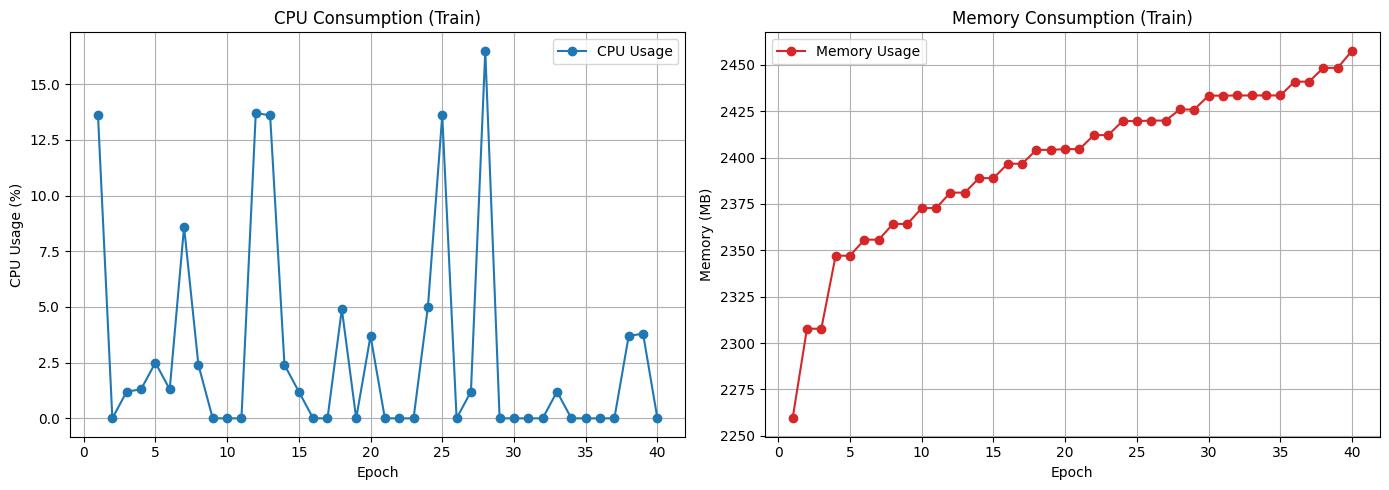

38105/38105 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 983us/step
1237/1237 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

====== Zero-Day: syn ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 12.50%, Memory: 2821.09 MB
[Epoch 1 - Fim] CPU: 4.90%, Memory: 2556.20 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 2556.21 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 2566.04 MB

[Epoch 3 - Início] CPU: 12.50%, Memory: 2566.01 MB
[Epoch 3 - Fim] CPU: 2.50%, Memory: 2581.87 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 2581.85 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 2588.09 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 2588.07 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 2599.00 MB

[Epoch 6 - Início] CPU: 0.00%, Memory: 2598.97 MB
[Epoch 6 - Fim] CPU: 1.20%, Memory: 2614.60 MB

[Epoch 7 - Início] CPU: 0.00%, Memory: 2614.57 MB
[Epoch 7 - Fim] CPU: 1.20%, Memory: 2621.86 MB

[Epoch 8 - Início] CPU: 0.00%, Memory: 2621.84 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 2627.92 MB

[Epoch 9 - Início] CPU

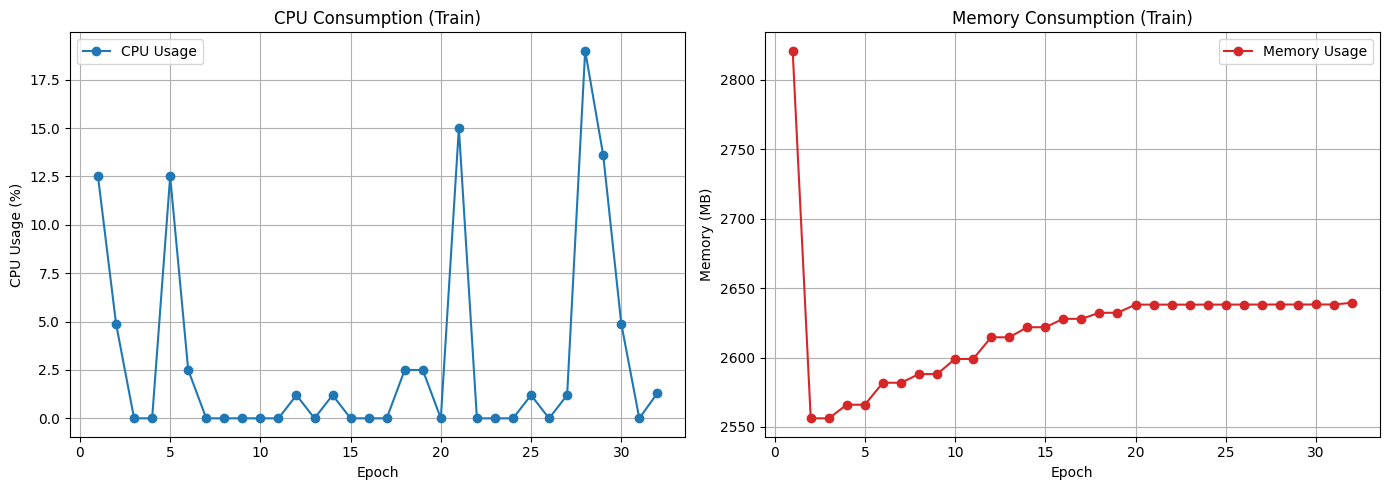

30437/30437 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
3168/3168 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

====== Zero-Day: icmp ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3149.71 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 2808.50 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 2808.48 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 2812.62 MB

[Epoch 3 - Início] CPU: 1.20%, Memory: 2812.60 MB
[Epoch 3 - Fim] CPU: 1.20%, Memory: 2831.00 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 2830.98 MB
[Epoch 4 - Fim] CPU: 2.50%, Memory: 2833.04 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 2833.02 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 2843.95 MB

[End of Training]
Total time: 115.85 seconds
Average CPU usage (Training): 0.49%
Average memory usage (Training): 2856.39 MB
Estimated energy consumption: 109.03 Joules


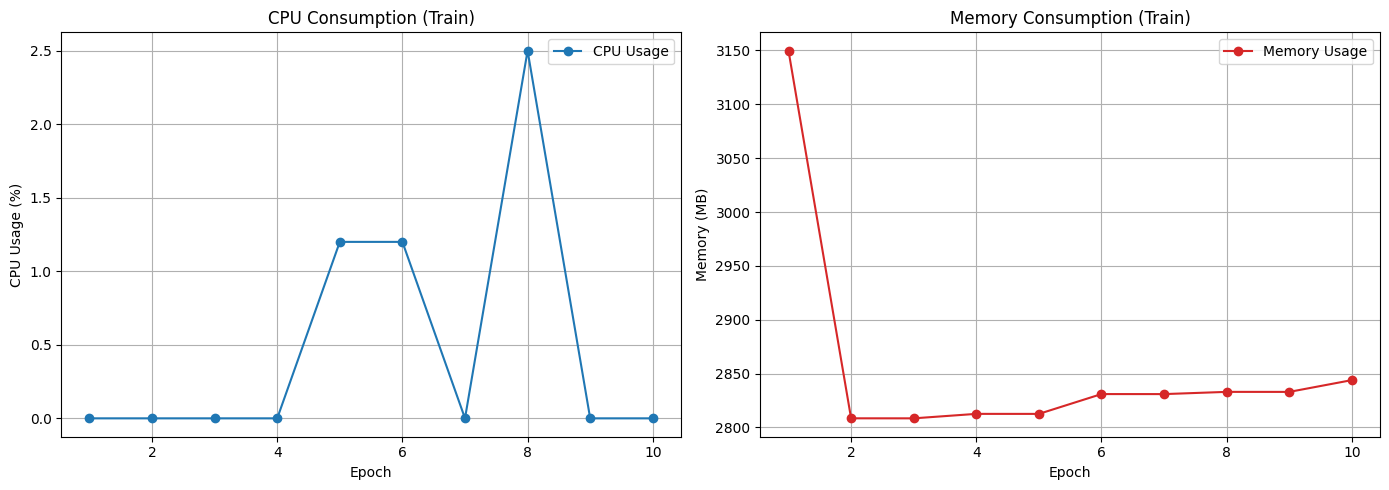

42479/42479 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

====== Zero-Day: slowloris ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3207.99 MB
[Epoch 1 - Fim] CPU: 1.20%, Memory: 2895.26 MB

[Epoch 2 - Início] CPU: 5.00%, Memory: 2895.24 MB
[Epoch 2 - Fim] CPU: 2.50%, Memory: 2921.79 MB

[Epoch 3 - Início] CPU: 3.80%, Memory: 2921.76 MB
[Epoch 3 - Fim] CPU: 2.50%, Memory: 2932.61 MB

[Epoch 4 - Início] CPU: 1.20%, Memory: 2932.58 MB
[Epoch 4 - Fim] CPU: 1.20%, Memory: 2943.75 MB

[Epoch 5 - Início] CPU: 17.30%, Memory: 2946.42 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 2958.64 MB

[End of Training]
Total time: 119.70 seconds
Average CPU usage (Training): 3.47%
Average memory usage (Training): 2955.60 MB
Estimated energy consumption: 40010.88 Joules


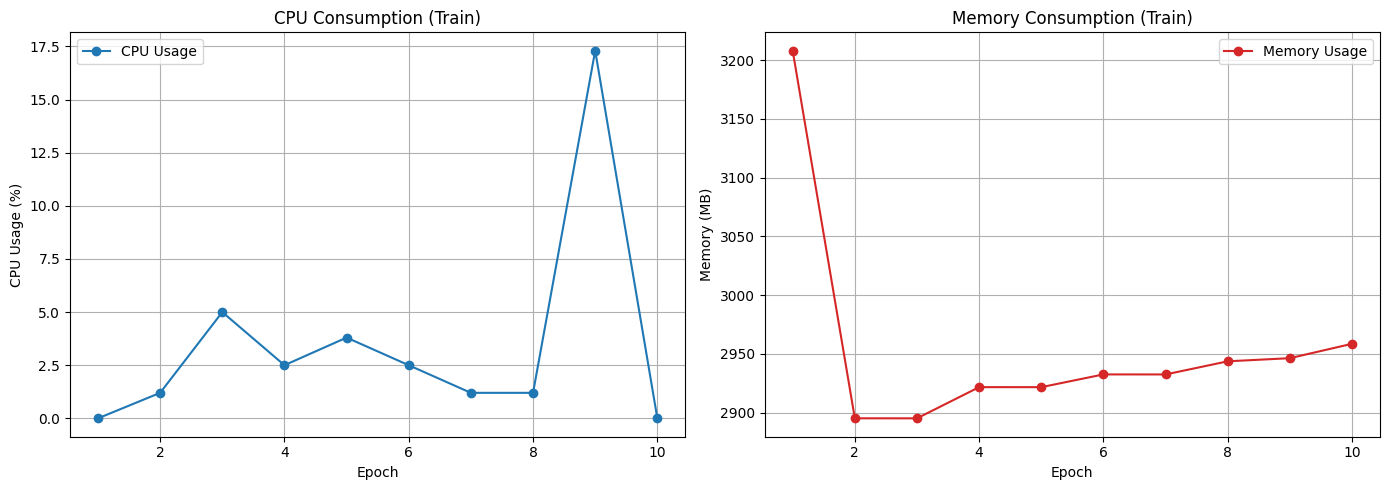

40723/40723 ━━━━━━━━━━━━━━━━━━━━ 40s 973us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

====== Zero-Day: udp ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3346.07 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 2891.85 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 2891.83 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 2900.12 MB

[Epoch 3 - Início] CPU: 1.20%, Memory: 2900.10 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 2915.95 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 2915.93 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 2918.10 MB

[Epoch 5 - Início] CPU: 1.20%, Memory: 2918.07 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 2918.23 MB

[Epoch 6 - Início] CPU: 0.00%, Memory: 2918.20 MB
[Epoch 6 - Fim] CPU: 0.00%, Memory: 2925.55 MB

[Epoch 7 - Início] CPU: 1.20%, Memory: 2925.53 MB
[Epoch 7 - Fim] CPU: 1.20%, Memory: 2933.13 MB

[Epoch 8 - Início] CPU: 0.00%, Memory: 2933.11 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 2933.20 MB

[Epoch 9 - Início] CPU: 

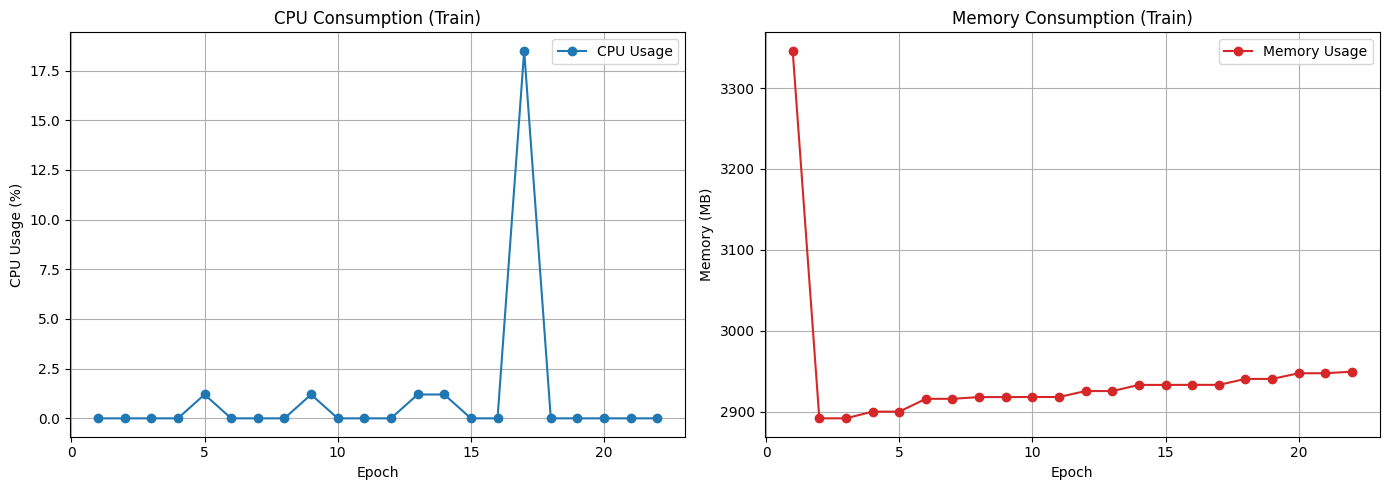

37419/37419 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 973us/step
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

====== Zero-Day: ssh ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3386.86 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3053.84 MB

[Epoch 2 - Início] CPU: 1.20%, Memory: 3053.82 MB
[Epoch 2 - Fim] CPU: 1.20%, Memory: 3087.31 MB

[Epoch 3 - Início] CPU: 0.00%, Memory: 3087.29 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3091.28 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3091.25 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3104.27 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3104.25 MB
[Epoch 5 - Fim] CPU: 1.30%, Memory: 3121.89 MB

[End of Training]
Total time: 118.04 seconds
Average CPU usage (Training): 0.37%
Average memory usage (Training): 3118.21 MB
Estimated energy consumption: 47.83 Joules


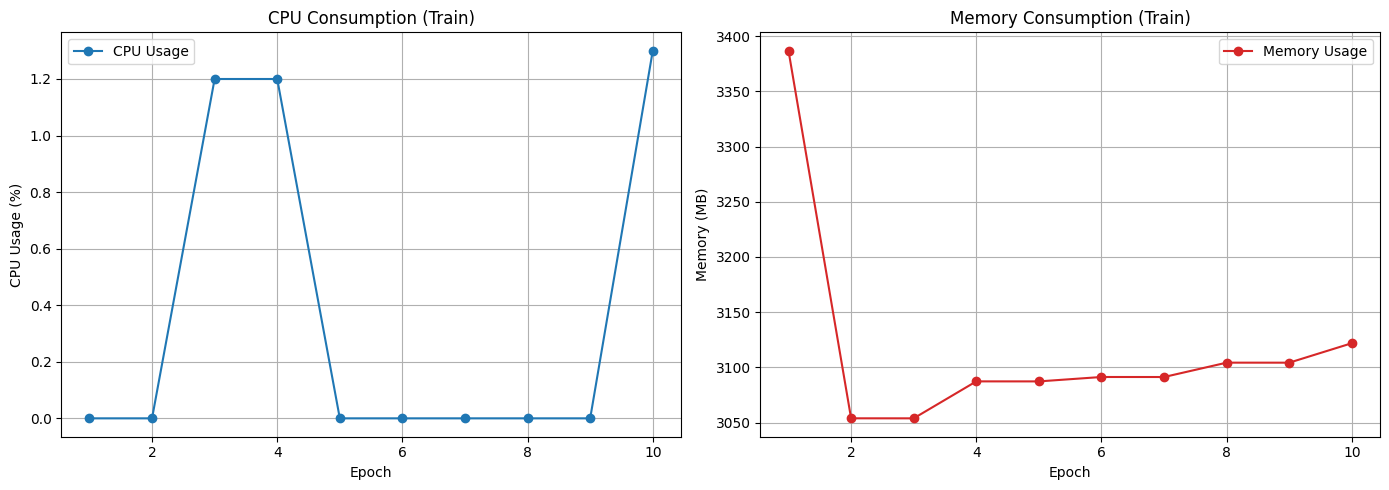

42721/42721 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step 
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

====== Zero-Day: ftp ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3429.72 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3104.10 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 3104.08 MB
[Epoch 2 - Fim] CPU: 1.20%, Memory: 3130.07 MB

[Epoch 3 - Início] CPU: 0.00%, Memory: 3130.04 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3146.04 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3146.02 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3151.34 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3151.31 MB
[Epoch 5 - Fim] CPU: 2.40%, Memory: 3152.49 MB

[End of Training]
Total time: 115.54 seconds
Average CPU usage (Training): 0.36%
Average memory usage (Training): 3164.52 MB
Estimated energy consumption: 43.12 Joules


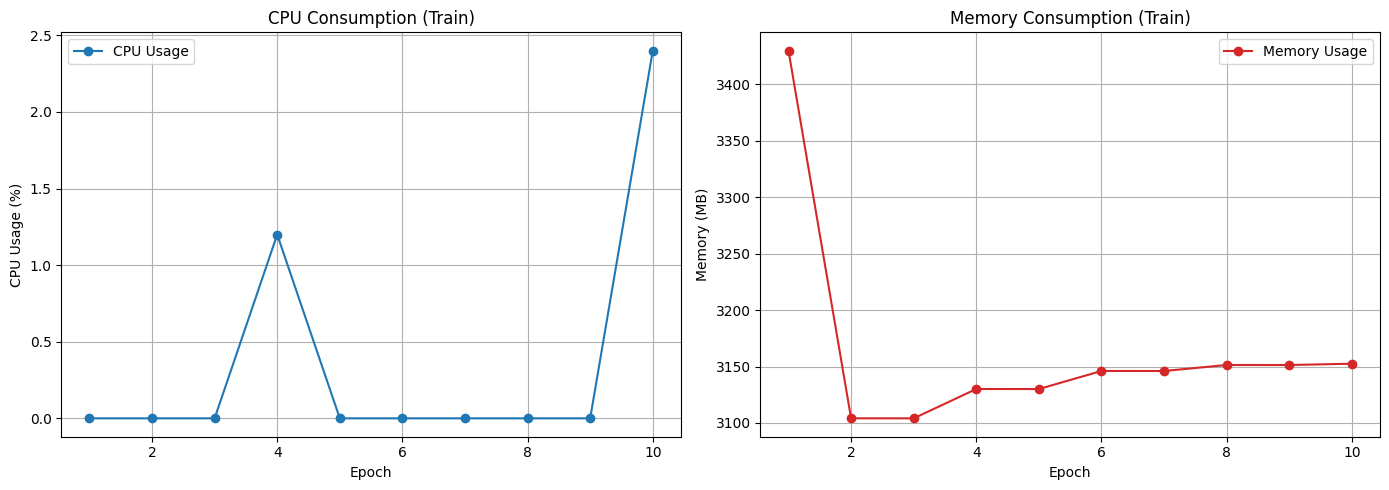

42755/42755 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

====== Zero-Day: portscan_tcp ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 3.70%, Memory: 3458.30 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3134.39 MB

[Epoch 2 - Início] CPU: 0.00%, Memory: 3134.38 MB
[Epoch 2 - Fim] CPU: 1.30%, Memory: 3143.94 MB

[Epoch 3 - Início] CPU: 3.80%, Memory: 3143.92 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3144.59 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3144.57 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3150.86 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3150.83 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3151.68 MB

[End of Training]
Total time: 111.17 seconds
Average CPU usage (Training): 0.88%
Average memory usage (Training): 3175.75 MB
Estimated energy consumption: 606.07 Joules


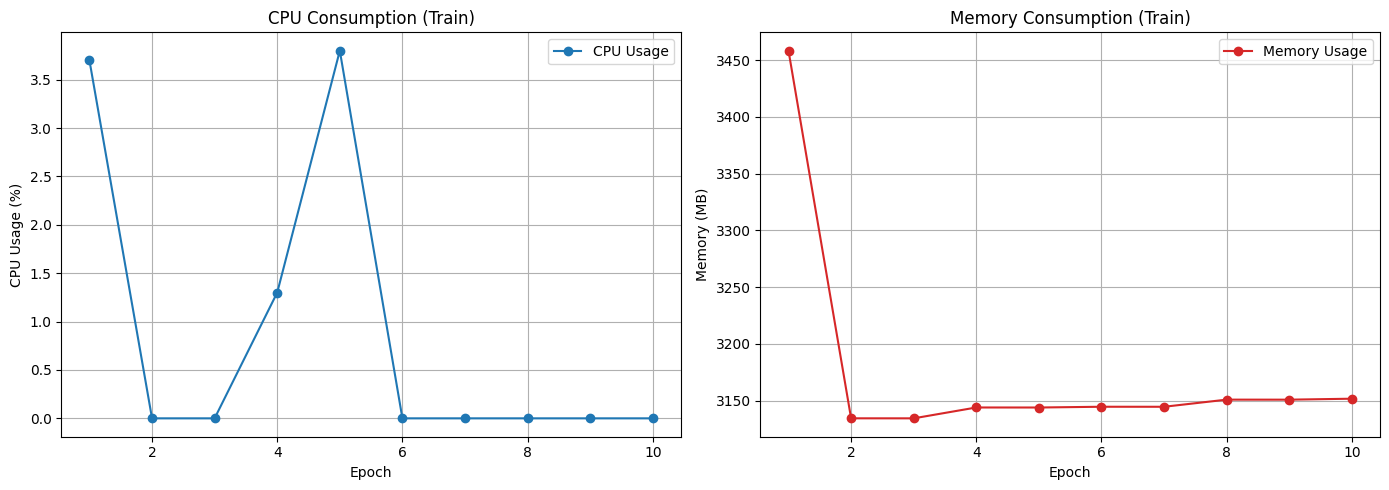

40590/40590 ━━━━━━━━━━━━━━━━━━━━ 40s 977us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 963us/step
619/619 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step

====== Zero-Day: os_fingerprinting ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 14.10%, Memory: 3469.62 MB
[Epoch 1 - Fim] CPU: 1.30%, Memory: 3186.13 MB

[Epoch 2 - Início] CPU: 13.90%, Memory: 3186.11 MB
[Epoch 2 - Fim] CPU: 11.40%, Memory: 3193.79 MB

[Epoch 3 - Início] CPU: 15.20%, Memory: 3193.76 MB
[Epoch 3 - Fim] CPU: 1.30%, Memory: 3204.71 MB

[Epoch 4 - Início] CPU: 1.30%, Memory: 3204.69 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3219.35 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3219.33 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3239.33 MB

[End of Training]
Total time: 113.13 seconds
Average CPU usage (Training): 5.85%
Average memory usage (Training): 3231.68 MB
Estimated energy consumption: 181193.08 Joules


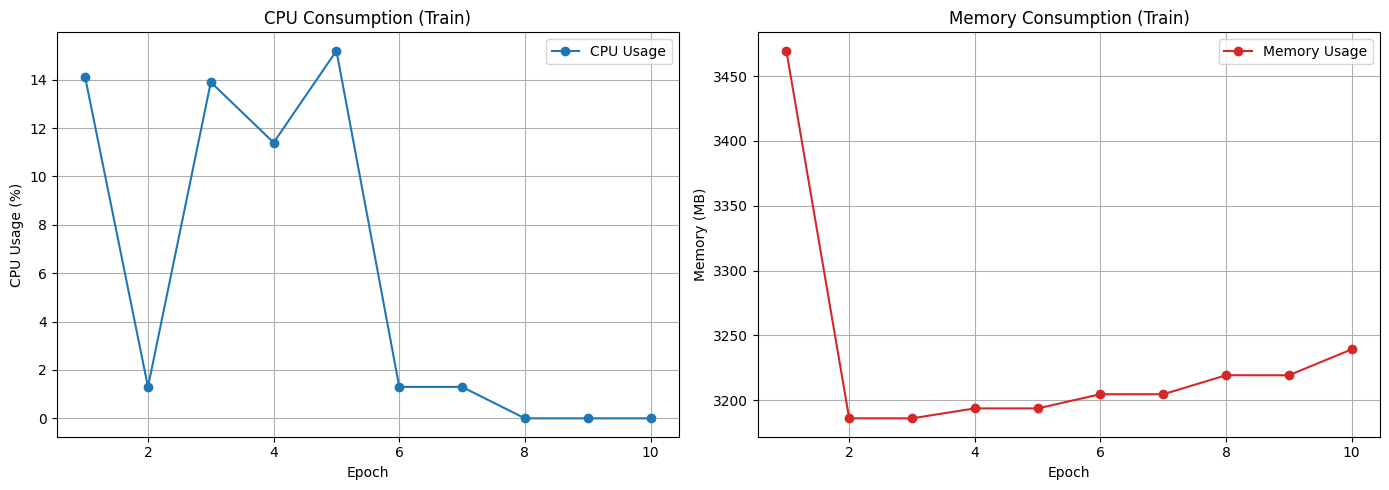

41525/41525 ━━━━━━━━━━━━━━━━━━━━ 39s 936us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

====== Zero-Day: portscan_udp ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3675.67 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3247.46 MB

[Epoch 2 - Início] CPU: 1.20%, Memory: 3247.44 MB
[Epoch 2 - Fim] CPU: 3.80%, Memory: 3302.25 MB

[Epoch 3 - Início] CPU: 1.20%, Memory: 3302.23 MB
[Epoch 3 - Fim] CPU: 13.60%, Memory: 3325.10 MB

[Epoch 4 - Início] CPU: 1.20%, Memory: 3325.07 MB
[Epoch 4 - Fim] CPU: 11.20%, Memory: 3329.20 MB

[Epoch 5 - Início] CPU: 12.50%, Memory: 3329.17 MB
[Epoch 5 - Fim] CPU: 1.20%, Memory: 3329.54 MB

[End of Training]
Total time: 112.67 seconds
Average CPU usage (Training): 4.59%
Average memory usage (Training): 3341.31 MB
Estimated energy consumption: 87160.57 Joules


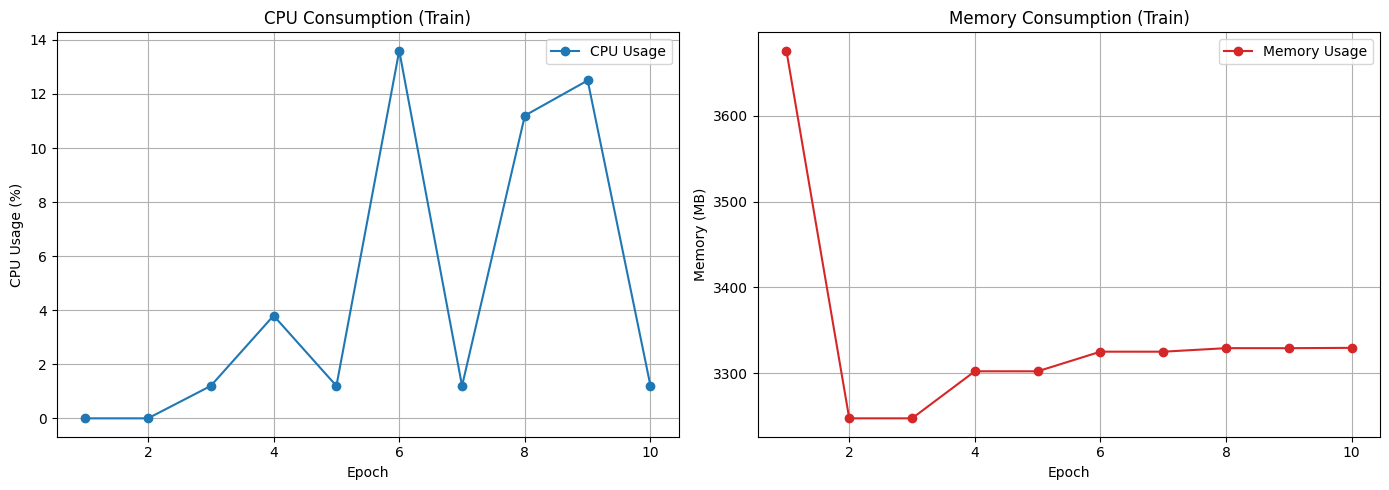

42587/42587 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 989us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

====== Zero-Day: http_flood ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 2.50%, Memory: 3492.89 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3207.32 MB

[Epoch 2 - Início] CPU: 2.50%, Memory: 3207.30 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3214.33 MB

[Epoch 3 - Início] CPU: 0.00%, Memory: 3214.30 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3214.74 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3214.71 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3222.55 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3222.52 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3231.97 MB

[End of Training]
Total time: 98.84 seconds
Average CPU usage (Training): 0.50%
Average memory usage (Training): 3244.26 MB
Estimated energy consumption: 98.84 Joules


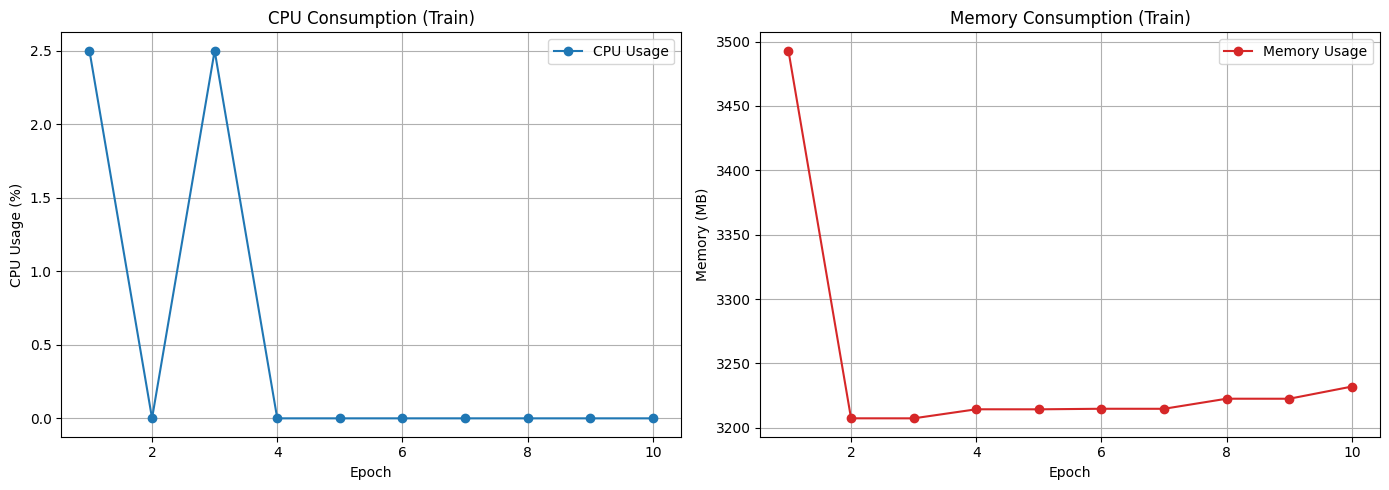

36735/36735 ━━━━━━━━━━━━━━━━━━━━ 34s 911us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step

====== Zero-Day: dir_bruteforce ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3719.96 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3346.52 MB

[Epoch 2 - Início] CPU: 3.70%, Memory: 3346.49 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3356.43 MB

[Epoch 3 - Início] CPU: 2.40%, Memory: 3356.40 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3356.99 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3356.96 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3371.75 MB

[Epoch 5 - Início] CPU: 1.30%, Memory: 3371.72 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3372.14 MB

[End of Training]
Total time: 117.39 seconds
Average CPU usage (Training): 0.74%
Average memory usage (Training): 3395.54 MB
Estimated energy consumption: 380.55 Joules


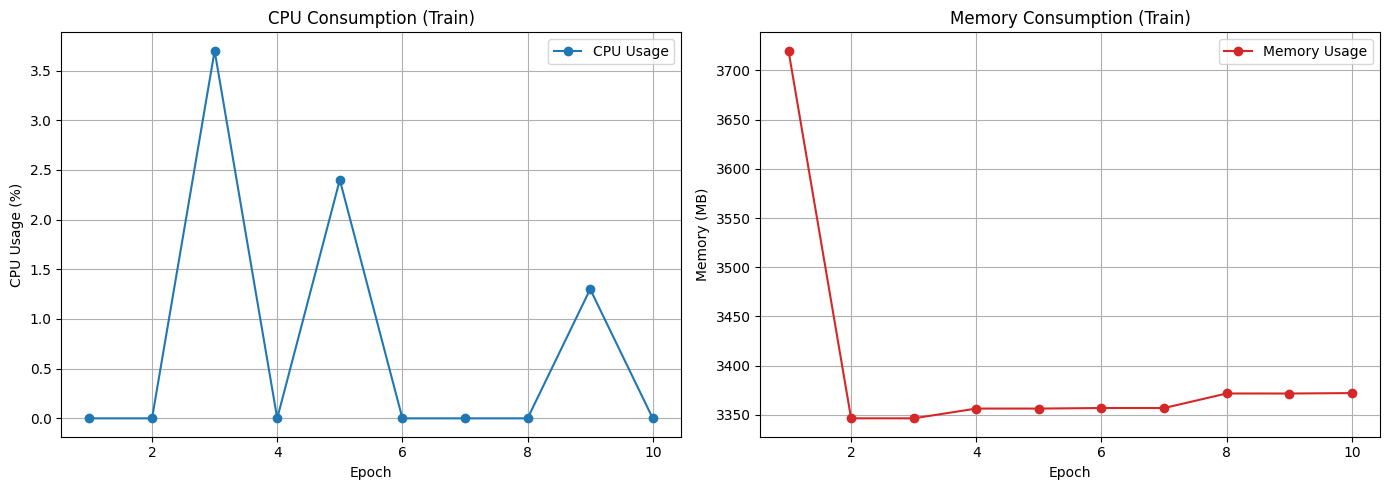

42382/42382 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

====== Zero-Day: xss ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3775.79 MB
[Epoch 1 - Fim] CPU: 2.50%, Memory: 3412.09 MB

[Epoch 2 - Início] CPU: 1.30%, Memory: 3412.06 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3431.50 MB

[Epoch 3 - Início] CPU: 1.30%, Memory: 3431.47 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3435.18 MB

[Epoch 4 - Início] CPU: 1.20%, Memory: 3435.16 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3443.57 MB

[Epoch 5 - Início] CPU: 0.00%, Memory: 3443.54 MB
[Epoch 5 - Fim] CPU: 17.30%, Memory: 3443.79 MB

[End of Training]
Total time: 110.82 seconds
Average CPU usage (Training): 2.36%
Average memory usage (Training): 3466.41 MB
Estimated energy consumption: 11652.65 Joules


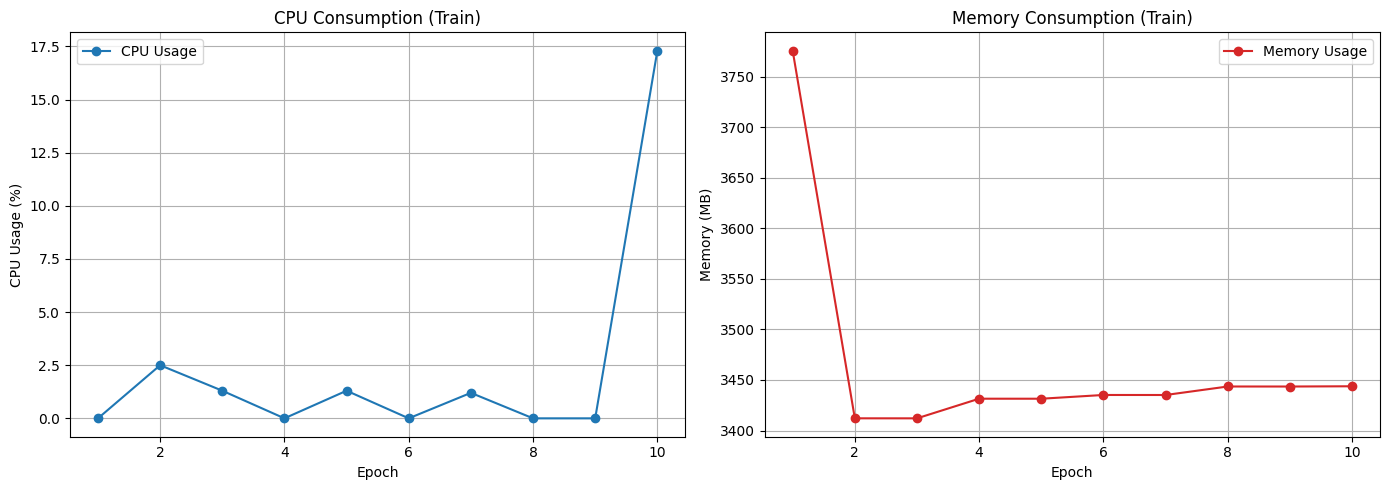

43005/43005 ━━━━━━━━━━━━━━━━━━━━ 39s 906us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 9s 859us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

====== Zero-Day: sql_injection ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3900.57 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3490.58 MB

[Epoch 2 - Início] CPU: 1.30%, Memory: 3490.56 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3514.48 MB

[Epoch 3 - Início] CPU: 1.20%, Memory: 3516.96 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3517.30 MB

[Epoch 4 - Início] CPU: 0.00%, Memory: 3517.27 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3517.85 MB

[Epoch 5 - Início] CPU: 1.20%, Memory: 3517.83 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3520.57 MB

[End of Training]
Total time: 114.36 seconds
Average CPU usage (Training): 0.37%
Average memory usage (Training): 3550.40 MB
Estimated energy consumption: 46.34 Joules


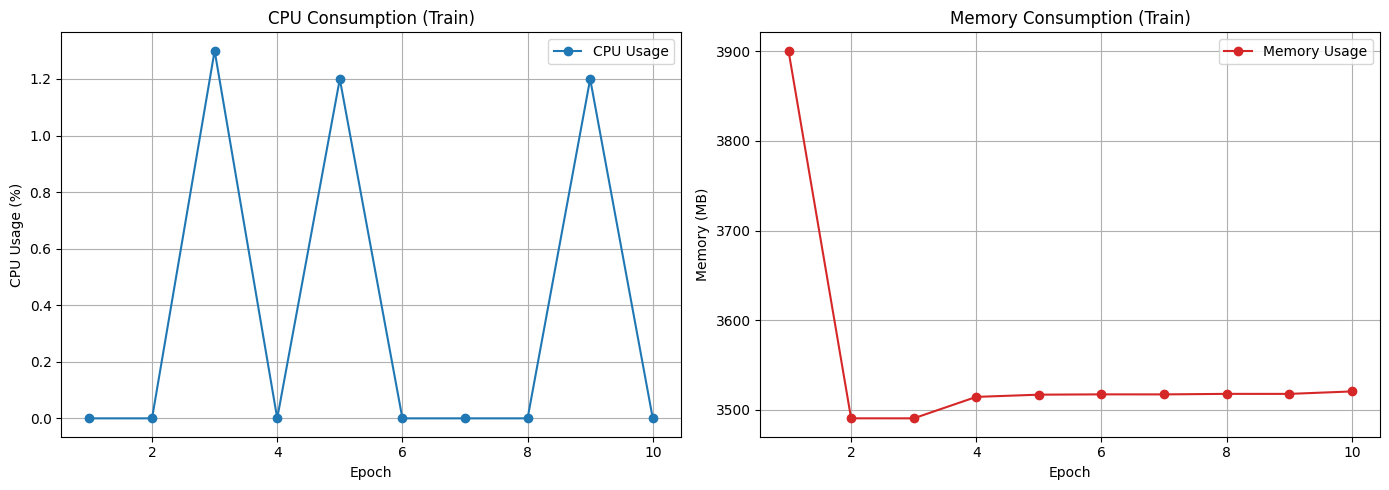

43051/43051 ━━━━━━━━━━━━━━━━━━━━ 39s 899us/step
10774/10774 ━━━━━━━━━━━━━━━━━━━━ 10s 968us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [19]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Configuração das features e rótulos
features = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes',
    'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'ip_proto',
    'http_trans_depth', 'files_total_bytes', 'is_GET_mthd',
    'http_status_error', 'is_file_transfered'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['attack_type'] = encoded.loc[X_train.index, 'attack_type']
X_test['attack_type'] = encoded.loc[X_test.index, 'attack_type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['tcp_ack', 'syn', 'icmp', 'slowloris', 'udp', 'ssh', 'ftp', 'portscan_tcp', 'os_fingerprinting', 'portscan_udp', 'http_flood', 'dir_bruteforce', 'xss', 'sql_injection']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

# ===== LOOP PRINCIPAL =====
resultados_zero_day = []

for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Separação dos dados ---
    train_indices = X_train[X_train['attack_type'] != ataque_zero_day].index
    test_indices = X_test[X_test['attack_type'] == ataque_zero_day].index

    X_train_clean = X_train.loc[train_indices].drop(columns=['attack_type'])
    y_train_clean = y_train.loc[train_indices]
    X_test_zero_day = X_test.loc[test_indices].drop(columns=['attack_type'])
    y_test_zero_day = y_test.loc[test_indices]
    X_test_full = X_test.drop(columns=['attack_type'])
    y_test_full = y_test

    # --- Apenas features numéricas ---
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    # --- Construção do Autoencoder ---
    input_dim = X_train_scaled.shape[1]
    encoding_dim = 32  # latente

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation="relu")(input_layer)
    encoded = Dense(encoding_dim, activation="relu")(encoded)
    decoded = Dense(64, activation="relu")(encoded)
    output_layer = Dense(input_dim, activation="sigmoid")(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")

    # --- Treinamento com monitoramento ---
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # --- Calcular erros de reconstrução ---
    recon_train = autoencoder.predict(X_train_scaled)
    train_errors = np.mean(np.power(X_train_scaled - recon_train, 2), axis=1)

    # Threshold = percentil 95 dos erros de treino
    threshold = np.percentile(train_errors, 95)

    # Função para calcular métricas
    def avaliar(autoencoder, X, y_true, threshold):
        recon = autoencoder.predict(X)
        errors = np.mean(np.power(X - recon, 2), axis=1)
        y_pred = (errors > threshold).astype(int)  # 1 = ataque, 0 = benigno
        return {
            "F1": f1_score(y_true, y_pred, zero_division=1),
            "Precision": precision_score(y_true, y_pred, zero_division=1),
            "Recall": recall_score(y_true, y_pred, zero_division=1),
            "Accuracy": accuracy_score(y_true, y_pred)
        }

    # Transformar rótulos em binário: benigno=0, ataque=1
    y_test_full_bin = (y_test_full != "BENIGN").astype(int)
    y_test_zero_day_bin = (y_test_zero_day != "BENIGN").astype(int)

    # Avaliar geral e zero-day
    metrics_full = avaliar(autoencoder, X_test_full_scaled, y_test_full_bin, threshold)
    metrics_zero_day = avaliar(autoencoder, X_test_zero_day_scaled, y_test_zero_day_bin, threshold)

    resultados_zero_day.append({
        "Ataque Zero-Day": ataque_zero_day,
        "Acurácia": metrics_full["Accuracy"],
        "F1": metrics_full["F1"],
        "Precision": metrics_full["Precision"],
        "Recall": metrics_full["Recall"],
        "ZD - Acurácia": metrics_zero_day["Accuracy"],
        "ZD - F1": metrics_zero_day["F1"],
        "ZD - Precision": metrics_zero_day["Precision"],
        "ZD - Recall": metrics_zero_day["Recall"]
    })

    del autoencoder
    gc.collect()
    K.clear_session()

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!pip install tabulate

In [22]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤═══════════╤═════════════╤═══════════╤═════════════════╤════════════╤══════════════════╤═══════════════╕
│ Ataque Zero-Day   │   Acurácia │        F1 │   Precision │    Recall │   ZD - Acurácia │    ZD - F1 │   ZD - Precision │   ZD - Recall │
╞═══════════════════╪════════════╪═══════════╪═════════════╪═══════════╪═════════════════╪════════════╪══════════════════╪═══════════════╡
│ tcp_ack           │  0.0551102 │ 0.104463  │           1 │ 0.0551102 │      0.0940074  │ 0.171859   │                1 │    0.0940074  │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┼─────────────────┼────────────┼──────────────────┼───────────────┤
│ syn               │  0.0356128 │ 0.0687762 │           1 │ 0.0356128 │      0.001401   │ 0.00279808 │                1 │    0.001401   │
├───────────────────┼────────────┼───────────┼─────────────┼───────────┼─────────────────┼────────────┼──────────────────┼───────────────┤
│ icmp              │  0.05

In [23]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')